# Variational Bayes for Gaussian Mixture Models using bijax

In [15]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import optax
import jax
import jax.numpy as jnp
from functools import partial

try:
    from bijax.advi import ADVI
except ModuleNotFoundError:
    %pip install git+https://github.com/patel-zeel/bijax.git
    from bijax.advi import ADVI
    
try:
    from probml_utils.plotting import savefig, latexify
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils.plotting import savefig, latexify

from bijax.utils import train_fn

from jax.config import config
config.update("jax_enable_x64", True)

latexify(width_scale_factor=2, fig_height=2)

(272, 2)


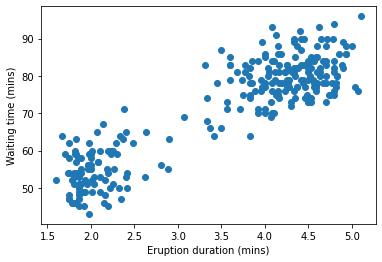

In [16]:
### Load data

data_url = "https://raw.githubusercontent.com/probml/probml-data/main/data/faithful.txt"
data = np.array(np.loadtxt(data_url))
print(data.shape)

plt.figure()
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel("Eruption duration (mins)")
plt.ylabel("Waiting time (mins)");

# Standardize the data (to simplify model fitting)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
data_normalized = (data - mean) / std

In [17]:
ncomponents = 10
ndata = data.shape[0]
ndims = data.shape[1]

prior = {"mixture_weights": tfd.Dirichlet(concentration=jnp.ones(ncomponents)), 
         "loc": tfd.Normal(loc=jnp.zeros((ncomponents, ndims)), scale=1.0),
         "scale": tfd.HalfNormal(scale=2 * jnp.ones((ncomponents, ndims))),
         "correlation_tril": tfd.CholeskyLKJ(dimension=ndims, concentration=jnp.ones(ncomponents))}

bijector = {"mixture_weights": tfb.SoftmaxCentered(), 
         "loc": tfb.Identity(),
         "scale": tfb.Exp(),
         "correlation_tril": tfb.CorrelationCholesky()}

def log_likelihood_fn(latent_sample, outputs, inputs, **kwargs):
    scale_tril = latent_sample["scale"][:, jnp.newaxis]*latent_sample["correlation_tril"]
    mixture_distribution = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=latent_sample["mixture_weights"]),
            components_distribution=tfd.MultivariateNormalTriL(loc=latent_sample["loc"], scale_tril=scale_tril))
    return mixture_distribution.log_prob(outputs).sum()

In [18]:
model = ADVI(prior, bijector, log_likelihood_fn)

In [22]:
seed = jax.random.PRNGKey(123)
params = model.init(seed)

loss_fn = partial(model.loss_fn, outputs=data_normalized, inputs=None, full_data_size=ndata, n_samples=100)

tx = optax.adam(learning_rate=2e-2)
seed = jax.random.PRNGKey(1)
results = train_fn(loss_fn, params, tx, n_epochs=1000, seed=seed, return_args={"losses"})

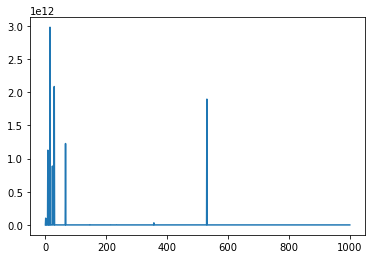

In [23]:
plt.plot(results['losses']);

## Helper functions for plotting

In [24]:
def plot_loc_scale(weight_, loc_, scale_tril_, color, ax):
    cov = np.dot(scale_tril_, scale_tril_.T)
    w, v = np.linalg.eig(cov)
    angle = np.arctan2(v[1, 0], v[1, 1]) * 360 / (2 * np.pi)
    height = 3 * np.sqrt(w[1])  # minor axis
    width = 3 * np.sqrt(w[0])  # major axis

    e = Ellipse(xy=loc_, width=width, height=height, angle=angle)
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(weight_)
    e.set_facecolor(color)
    e.set_edgecolor("black")

def plot_posterior_with_data(posterior_sample, data, ax, facecolors=None):
    loc_ = posterior_sample['loc']
    ax.plot(data[:, 0], data[:, 1], "k.", markersize=3, label='data')
    ax.plot(loc_[:, 0], loc_[:, 1], "r^", markersize=3, label='loc')

    np.random.seed(420)
    if facecolors is None:
        facecolors = sns.color_palette("deep", n_colors=ncomponents)

    weights_ = np.power(posterior_sample['mixture_weights'], 0.8)  # larger power means less emphasis on low weights
    weights_ = weights_ * (0.5 / np.max(weights_))
    scale_tril = posterior_sample["scale"][:, jnp.newaxis]*posterior_sample["correlation_tril"]
    for i, (weight_, l_, st_) in enumerate(zip(weights_, loc_, scale_tril)):
        plot_loc_scale(weight_, l_, st_, color=facecolors[i], ax=ax)
        
    ax.legend()

def plot_posterior_sample(surrogate_posterior, data, seed):
    posterior_sample = surrogate_posterior.sample(seed=seed)
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
    plot_posterior_with_data(posterior_sample, data=data, ax=ax[0])
    
    sns.barplot(y=np.arange(ncomponents), x=posterior_sample['mixture_weights'], ax=ax[1], palette="deep", orient='horizontal')
    ax[1].set_ylabel('Mixture components')
    ax[1].set_xlabel('Weights')
    sns.despine()
#     ax.set_title("Mixture component weights")

/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


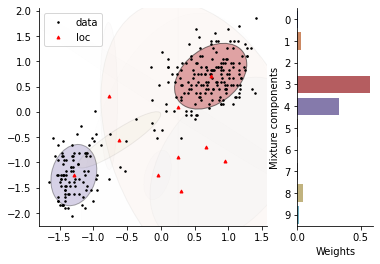

In [25]:
surrogate_posterior = model.apply(results['params'])

seed = jax.random.PRNGKey(12)
plot_posterior_sample(surrogate_posterior, data=data_normalized, seed=seed)
savefig("vb_gmm_bayes_sample1")

/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


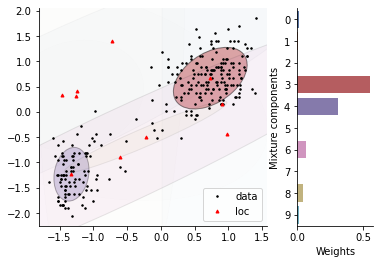

In [26]:
surrogate_posterior = model.apply(results['params'])

seed = jax.random.PRNGKey(34)
plot_posterior_sample(surrogate_posterior, data=data_normalized, seed=seed)
savefig("vb_gmm_bayes_sample2")

/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


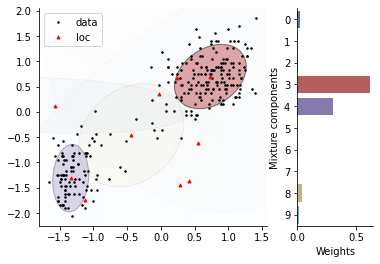

In [27]:
surrogate_posterior = model.apply(results['params'])

seed = jax.random.PRNGKey(56)
plot_posterior_sample(surrogate_posterior, data=data_normalized, seed=seed)
savefig("vb_gmm_bayes_sample3")

In [28]:
surrogate_posterior = model.apply(results['params'])

seed = jax.random.PRNGKey(1234)
sample = surrogate_posterior.sample(seed=seed)
jax.tree_map(lambda x: x.shape, sample)

{'correlation_tril': (10, 2, 2),
 'loc': (10, 2),
 'mixture_weights': (10,),
 'scale': (10, 2)}